# Example on the urban canopy data 

In [79]:
from pivpy import io, graphics, pivpy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pkg_resources as pkg
%matplotlib inline

In [80]:
from lvreader import read_buffer
# import pathlib
# vc7file = pathlib.Path('../../pivpy/data/VC7/2d2c/2Ca.vc7')
buffer = read_buffer(pkg.resource_filename('pivpy','data/urban_canopy/B00001.vc7'))
print(buffer)

Buffer(frames=[VectorFrame(components=<21 components: U0, V0, U1, V1, U2, V2, U3, V3, ACTIVE_CHOICE, ENABLED, TS:Peak ratio, MASK, TS:Correlation value, TS:IntWin type, TS:IntWin factor X, TS:IntWin factor Y, TS:IntWin angle, TS:Particle size, TS:Uncertainty V, TS:Uncertainty Vx, TS:Uncertainty Vy>, scales=Scales(x=Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'), y=Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'), z=Scale(slope=1.0, offset=0.0, unit='pixel', description=''), i=Scale(slope=0.268812, offset=0.0, unit='m/s', description='velocity')), attributes={'Acq.Time': array([[19247.7]]), 'AcqTimeSeries': '178439.840 µs', 'AvgCorrValue': '0.493753', 'CameraName': '1 1', 'CellSizeOrientation': '1', 'CorrelationAlgorithm': '0', 'FrameDt': '300 us', 'FrameProcessing': '0', 'InterrogationWindowSize': '32', 'MultiPassSmoothingMode': '5', 'PixelInterpolationMode': '8', 'Platform': '0', 'ShiftCorrectionMode': '0', 'VectorInterpolationMode

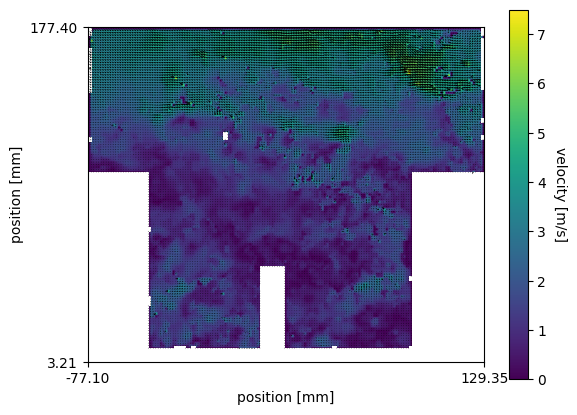

In [81]:
buffer.plot()

In [95]:
buffer[0].shape, buffer[0].enabled

((135, 160),
 [array([[0, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)])

In [124]:
data = buffer[0]
data.shape, data.scales, data.enabled

((135, 160),
 Scales(x=Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'), y=Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'), z=Scale(slope=1.0, offset=0.0, unit='pixel', description=''), i=Scale(slope=0.268812, offset=0.0, unit='m/s', description='velocity')),
 [array([[0, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)])

In [134]:
getattr(data.scales, 'x'), getattr(data.scales, 'y')

(Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'),
 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'))

In [135]:
data.shape

(135, 160)

In [136]:
135*0.08

10.8

In [115]:
def _scale_masked_array_in_place(arr) -> None:
    u = arr["u"]
    v = arr["v"]
    u[:] = arr._scaled_intensity(u) * np.sign(arr.scales.x.slope)
    v[:] = arr._scaled_intensity(v) * np.sign(arr.scales.y.slope)
    if self.is_3c:
        w = arr["w"]
        w[:] = arr._scaled_intensity(w) * np.sign(arr.scales.z.slope)

In [116]:
unscaled = data._as_unscaled_masked_array(plane)
scaled = unscaled.copy()
_scale_masked_array_in_place(scaled)


AttributeError: 'MaskedArray' object has no attribute '_scaled_intensity'

In [ ]:
def plot_vector_field(uvw_unscaled, uvw_scaled, is_3c, scales, grids, *, show=True):
    import matplotlib.pyplot as plt

    u = uvw_scaled["u"]
    v = uvw_scaled["v"]
    if is_3c:
        w = uvw_scaled["w"]

    if is_3c:
        background = np.ma.sqrt(u * u + v * v + w * w)
    else:
        background = np.ma.sqrt(u * u + v * v)

    fig, ax = plt.subplots()
    ax.imshow(background)
    ax.quiver(uvw_unscaled["u"], uvw_unscaled["v"], angles='xy', width=0.002)

    prettify_plot(fig, scales, grids)

    if show:
        plt.show()
    else:
        return fig

In [ ]:
def scaled_coordinate(value, axis, scales, grids):
    # we want 0 to be top left edge, not center of top left pixel/vector:
    corrected = value + 0.5
    grid = 1 if grids is None else getattr(grids, axis)
    scale = getattr(scales, axis)
    return corrected * grid * scale.slope + scale.offset

In [ ]:
def prettify_plot(fig, scales, grids=None):
    """
    Adorns a given figure with labels and a color bar.
    Also sets exactly two ticks on each axis (one at each end)
    to make the data range clearly visible, and rounds their labels
    if possible without them becoming indistinguishable.
    """
    from matplotlib.ticker import FuncFormatter, LinearLocator

    [ax] = fig.axes
    ax.xaxis.set_major_locator(LinearLocator(2))
    ax.yaxis.set_major_locator(LinearLocator(2))

    def make_formatter(axis, *, rounded):
        @FuncFormatter
        def formatter(value, _=None):
            scaled = scaled_coordinate(value, axis, scales, grids)
            return f"{scaled:.2f}" if rounded else f"{scaled}"
        return formatter

    def determine_suitable_formatter(axis):
        if axis == "x":
            ticks = ax.get_xticks()
        else:
            ticks = ax.get_yticks()
        first, last = ticks  # we expect there to be exactly two ticks
        # if ticks have same label after rounding, then don't round
        formatter = make_formatter(axis, rounded=True)
        if formatter(first) == formatter(last):
            formatter = make_formatter(axis, rounded=False)
        return formatter

    ax.xaxis.set_major_formatter(determine_suitable_formatter("x"))
    ax.yaxis.set_major_formatter(determine_suitable_formatter("y"))

    ax.set_xlabel(scales.x.label())
    ax.set_ylabel(scales.y.label())

    [image] = ax.images
    colorbar = fig.colorbar(image)
    colorbar.ax.yaxis.labelpad = 15
    colorbar.ax.set_ylabel(scales.i.label(), rotation=270)

In [ ]:

return plot_vector_field(
    unscaled,
    scaled,
    self.is_3c,
    self.scales,
    self.grid,
    show=show
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

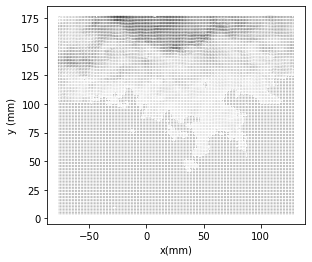

In [ ]:
graphics.quiver(data.isel(t=-1),arrScale=100) # show last

In [ ]:
# let's try a vertical profile

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

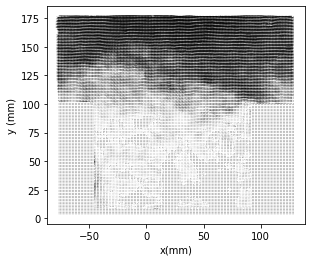

In [ ]:
graphics.quiver(data.piv.average,arrScale=50)

Text(0, 0.5, 'z (mm)')

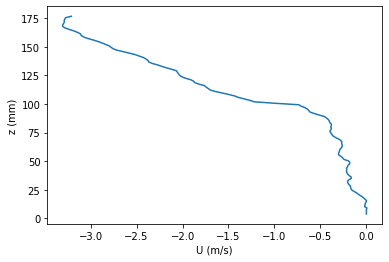

In [ ]:
# Let's try vertical profile of streamwise mean velocity U(z)
# we could define it a shortcut of the type:
# graphics.profile(velocity_component = 'u', coordinate = 'z') 
plt.plot(data.mean(dim='x').mean(dim='t').u,data.y)
plt.xlabel('U (m/s)')
plt.ylabel('z (mm)')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

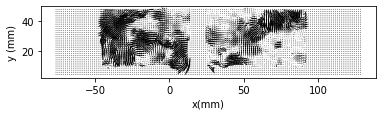

In [ ]:
graphics.quiver(data[dict(y=slice(100, 175))])
# something strange with the mask

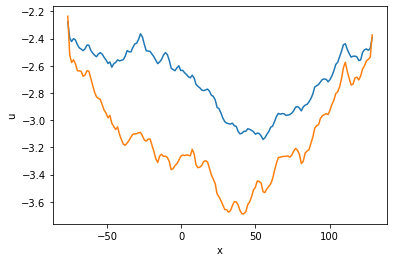

In [ ]:
# let's test homogeneity above the canopy: 
# take y above some value and .mean(dim='y')
# take mean with time .mean(dim='t')
# plot:
data.where(data.y>120,drop=True).mean(dim='t').mean(dim='y').u.plot()
data.where(data.y>150,drop=True).mean(dim='t').mean(dim='y').u.plot()

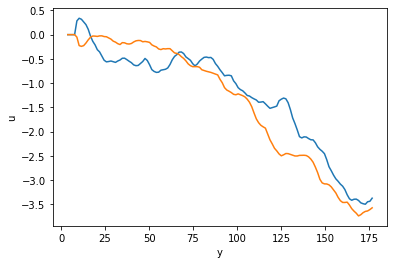

In [ ]:
data.where((data.x > -40) & (data.x < 0), drop=True).mean(dim='t').u.mean(dim='x').plot()
data.where((data.x > 20) & (data.x < 80), drop=True).mean(dim='t').u.mean(dim='x').plot()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

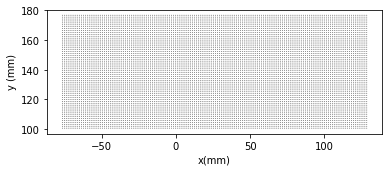

In [ ]:
graphics.quiver(data.where(data.y>100,drop=True).mean(dim='t'),units=['mm','mm','m/s','m/s'],arrScale=500)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

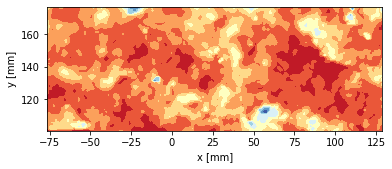

In [ ]:
# and some cool plot of average TKE above the canopy 
graphics.contour_plot(data.piv.tke().mean(dim='t').where(data.y > 100,drop=True),units=data.attrs['units'])